In [71]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

from shapely.ops import unary_union
from shapely import wkt

In [19]:
root = Path.cwd().parent / "resources" / 'live_data' / '2024-03-06_15'

In [42]:
# n = pypsa.Network(root / 'network_s_nodal.nc')
# n = pypsa.Network(root.parent.parent / 'networks' / 'gen.nc')
n = pypsa.Network(root.parent.parent.parent / 'data' / 'base.nc')

regions = gpd.read_file(Path.cwd().parent / 'data' / 'fti_zones.geojson').set_index('name')['geometry']

INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, transformers


In [48]:
regions = gpd.GeoDataFrame(geometry=[unary_union(regions.buffer(0.01))])

C:\Users\lukas\AppData\Local\Temp\ipykernel_26336\2360113842.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions = gpd.GeoDataFrame(geometry=[unary_union(regions.buffer(0.01))])


Line
11524    LINESTRING(0.045578761779173 51.9284031200229,...
8702     LINESTRING(0.610675348991046 51.8679561093672,...
8704     LINESTRING(0.610934961776826 51.8682655405378,...
8703     LINESTRING(0.611038201010237 51.8682846722364,...
14745    LINESTRING(1.02403056427207 52.0414815110812,0...
                               ...                        
6216     LINESTRING(-2.136841 53.213435,-2.169799999999...
6218     LINESTRING(-2.16979999999999 53.243852,-2.1093...
8126     LINESTRING(0.015106000000011 51.832383,0 51.78...
8125     LINESTRING(0.015106000000011 51.832383,0 51.82...
5185     LINESTRING(0.015106000000011 51.832383,0.04523...
Name: geometry, Length: 479, dtype: object

In [53]:
buses = gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y))
buses = buses.loc[buses.geometry.within(regions.geometry[0])]

In [70]:
type(n.lines.geometry.iloc[0])

str

In [90]:
lines = gpd.GeoDataFrame(n.lines, geometry=[wkt.loads(x) for x in n.lines.geometry])
lines = lines.loc[lines.bus0.isin(buses.index) & lines.bus1.isin(buses.index)]
links = gpd.GeoDataFrame(n.links, geometry=[wkt.loads(x) for x in n.links.geometry])
links = links.loc[links.bus0.isin(buses.index) & links.bus1.isin(buses.index)]

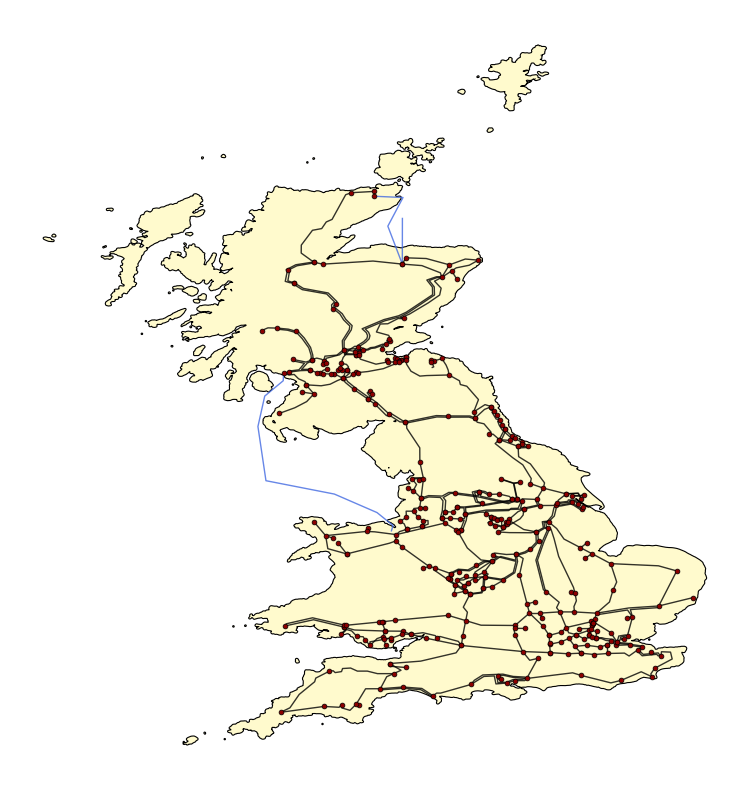

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

regions.plot(ax=ax, edgecolor='black', facecolor='lemonchiffon', alpha=1, zorder=0, linewidth=0.8)
lines.plot(ax=ax, color='black', linewidth=1, alpha=0.8, zorder=1)
links.plot(ax=ax, color='royalblue', linewidth=1, alpha=0.8, zorder=1)
ax.scatter(buses.x, buses.y, s=12, color='darkred', edgecolor='black', alpha=1, linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('network_layout.pdf')

plt.show()